# Predict late shipments

While delays may be unavoidable, retailers and manufacturers have the ability to manage any negative impact that delays have on their supply chain, by foreseeing and mitigating potential disruptions. The difficulty in doing so today is that retailers and manufacturers are ill equipped with a lack of forward looking information. However, through the use of AI, supply chain managers can proactively anticipate irregularities in the supply chain by predicting whether deliveries will arrive on time for both outbound and inbound shipments. Using historical shipment data and features associated with deliveries such as weather and port traffic, AI learns patterns associated with on-time and late deliveries to accurately classify future shipments into either bucket and offers the top statistical reasons why. Based on this information, supply chain managers are able to implement changes that prevent avoidable late deliveries, and to mitigate the risks that stem from unavoidable late deliveries.

### Import libraries

In [ ]:
import datarobot as dr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
dr.Client()
# The `config_path` should only be specified if the config file is not in the default location described in the API Quickstart guide
# dr.Client(config_path='path-to-drconfig.yaml')

## Import data

DataRobot hosts the dataset used in this notebook: access it via the URL in the following paragraph (`data_path`). Read in the data directly from the URL into a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and display the results to verify all of the data looks correct.

In [16]:
data_path = "https://pathfinder.datarobot.com/wp-content/uploads/2020/06/Pathfinder_Training_Predict-Parts-Shortage.csv"

pathfinder_df = pd.read_csv(data_path, encoding="ISO-8859-1")

pathfinder_df.head(100)

ID        Country Managed By  Fulfill Via Vendor INCO Term  \
0      1  Cªte d'Ivoire   PMO - US  Direct Drop              EXW   
1      3        Vietnam   PMO - US  Direct Drop              EXW   
2      4  Cªte d'Ivoire   PMO - US  Direct Drop              FCA   
3     15        Vietnam   PMO - US  Direct Drop              EXW   
4     16        Vietnam   PMO - US  Direct Drop              EXW   
..   ...            ...        ...          ...              ...   
95  1048          Haiti   PMO - US  Direct Drop              FCA   
96  1063   South Africa   PMO - US  Direct Drop              DDP   
97  1065   South Africa   PMO - US  Direct Drop              DDP   
98  1066   South Africa   PMO - US  Direct Drop              DDP   
99  1067   South Africa   PMO - US  Direct Drop              DDP   

   Shipment Mode  Late_delivery Product Group Sub Classification  \
0            Air              0          HRDT           HIV test   
1            Air              0           ARV          Pediatric   
2            Air              0          HRDT           HIV test   
3            Air              0           ARV              Adult   
4            Air              0           ARV              Adult   
..           ...            ...           ...                ...   
95           Air              0           ARV          Pediatric   
96           Air              0           ARV              Adult   
97           Air              0           ARV              Adult   
98           Air              0           ARV          Pediatric   
99           Air              0           ARV          Pediatric   

                                               Vendor  ...  \
0                         RANBAXY Fine Chemicals LTD.  ...   
1                            Aurobindo Pharma Limited  ...   
2                                Abbott GmbH & Co. KG  ...   
3   SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...  ...   
4                            Aurobindo Pharma Limited  ...   
..                                                ...  ...   
95    ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV)  ...   
96                                 S. BUYS WHOLESALER  ...   
97                                 S. BUYS WHOLESALER  ...   
98                                 S. BUYS WHOLESALER  ...   
99                                 S. BUYS WHOLESALER  ...   

   Unit of Measure (Per Pack) Line Item Quantity Line Item Value Pack Price  \
0                          30                 19          551.00      29.00   
1                         240               1000         6200.00       6.20   
2                         100                500        40000.00      80.00   
3                          60              31920       127360.80       3.99   
4                          60              38000       121600.00       3.20   
..                        ...                ...             ...        ...   
95                         60                 46          472.88      10.28   
96                         30               3025        47522.75      15.71   
97                         30               3500        49840.00      14.24   
98                        240               1008         3588.48       3.56   
99                        200                960         1152.00       1.20   

   Unit Price             Manufacturing Site  First Line Designation  \
0        0.97     Ranbaxy Fine Chemicals LTD                     Yes   
1        0.03      Aurobindo Unit III, India                     Yes   
2        0.80  ABBVIE GmbH & Co.KG Wiesbaden                     Yes   
3        0.07  Ranbaxy, Paonta Shahib, India                     Yes   
4        0.05      Aurobindo Unit III, India                     Yes   
..        ...                            ...                     ...   
95       0.17    ABBVIE Ludwigshafen Germany                     Yes   
96       0.52      Aurobindo Unit III, India                     Yes   
97       0.47              Cip

### Visualize data

Below, view several examples of charts that visualize the dataset in different ways such as grouping by shipment method, average delivery time, and vendor.

In [5]:
df1 = (
    pathfinder_df.where(pathfinder_df["Late_delivery"] == 1)
    .groupby("Shipment Mode")
    .agg({"Late_delivery": "count"})
)
df2 = (
    pathfinder_df.where(pathfinder_df["Late_delivery"] == 0)
    .groupby("Shipment Mode")
    .agg({"Late_delivery": "count"})
)
df_perc = df1 / (df2 + df1)
df_perc = df_perc.reset_index()  # doing this prevents html getting displayed on the x-axis

df_perc

Shipment Mode  Late_delivery
0           Air       0.096025
1   Air Charter       0.115385
2         Ocean       0.175202
3         Truck       0.160777

In [6]:
avg_value_df = pathfinder_df.groupby("Late_delivery").mean()
avg_value_df["Late_delivery_str"] = ["On time", "Late"]
avg_value_df = avg_value_df.reset_index()

avg_value_df

Late_delivery            ID  Unit of Measure (Per Pack)  \
0              0  48029.306741                   78.459400   
1              1  74750.373524                   74.381113   

   Line Item Quantity  Line Item Value  Pack Price  Unit Price  \
0        17182.398446    149764.739150   22.880866    0.655286   
1        27194.209949    218410.009224   14.431686    0.275885   

   Weight (Kilograms)  Freight Cost (USD)  Line Item Insurance (USD)  \
0         3258.892469        10823.199763                 229.296219   
1         4656.080795        13156.072446                 321.186624   

  Late_delivery_str  
0           On time  
1              Late

In [7]:
avg_value_df = pathfinder_df.groupby("Late_delivery").mean().replace("0", "On time")
avg_value_df["Display"] = ["On time", "Late"]

avg_value_df

ID  Unit of Measure (Per Pack)  Line Item Quantity  \
Late_delivery                                                                 
0              48029.306741                   78.459400        17182.398446   
1              74750.373524                   74.381113        27194.209949   

               Line Item Value  Pack Price  Unit Price  Weight (Kilograms)  \
Late_delivery                                                                
0                149764.739150   22.880866    0.655286         3258.892469   
1                218410.009224   14.431686    0.275885         4656.080795   

               Freight Cost (USD)  Line Item Insurance (USD)  Display  
Late_delivery                                                          
0                    10823.199763                 229.296219  On time  
1                    13156.072446                 321.186624     Late

In [17]:
from pandas import DataFrame

df1 = (
    pathfinder_df.where(pathfinder_df["Late_delivery"] == 1)
    .groupby("Vendor")
    .agg({"Late_delivery": "count"})
)
df2 = (
    pathfinder_df.where(pathfinder_df["Late_delivery"] == 0)
    .groupby("Vendor")
    .agg({"Late_delivery": "count"})
)

df_perc = df1 / (df2 + df1)
df_perc = df_perc.reset_index()

df_perc

Vendor  Late_delivery
0                   ABBOTT LABORATORIES (PUERTO RICO)            NaN
1                               ABBOTT LOGISTICS B.V.            NaN
2     ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV)       0.011527
3   ABBVIE, SRL (FORMALLY ABBOTT LABORATORIES INTE...            NaN
4                                    ACCESS BIO, INC.            NaN
..                                                ...            ...
68                        THE MEDICAL EXPORT GROUP BV            NaN
69     TURE PHARMACEUTICALS & MEDICAL SUPPLIES P.L.C.            NaN
70                               Trinity Biotech, Plc       0.002809
71                                            WAGENIA            NaN
72                                 ZEPHYR BIOMEDICALS            NaN

[73 rows x 2 columns]

## Modeling
 
For this use case, create a DataRobot project and initiate modeling by running Autopilot in Quick mode.

In [18]:
EXISTING_PROJECT_ID = None  # If you've already created a project, replace None with the ID here
if EXISTING_PROJECT_ID is None:
    # Create project and pass in data
    project = dr.Project.create(sourcedata=pathfinder_df, project_name="Predicting Late Shipments")

    # Set the project target to the appropriate feature. Use the LogLoss metric to measure performance
    project.set_target(target="Late_delivery", mode=dr.AUTOPILOT_MODE.QUICK, worker_count="-1")
else:
    # Fetch the existing project
    project = dr.Project.get(EXISTING_PROJECT_ID)

project.wait_for_autopilot(check_interval=30)


# Get the project metric (i.e LogLoss, RMSE, etc.)
metric = project.metric

# Get the project ID
# project_id = project.id
# project_id

### View project in UI

If you want to view the project in the DataRobot UI, use the following snippet to retrieve the project's URL and use it to navigate to the application.

In [31]:
# Get project URL
project_url = project.get_leaderboard_ui_permalink()
project_url

'https://app.datarobot.com/projects/62e1533d3ee0c70bc69f0023/models'

### Initiate Autopilot

In [19]:
project.wait_for_autopilot(check_interval=30)

In progress: 4, queued: 0 (waited: 0s)
In progress: 4, queued: 0 (waited: 0s)
In progress: 4, queued: 0 (waited: 1s)
In progress: 4, queued: 0 (waited: 2s)
In progress: 4, queued: 0 (waited: 3s)
In progress: 4, queued: 0 (waited: 5s)
In progress: 4, queued: 0 (waited: 8s)
In progress: 4, queued: 0 (waited: 15s)
In progress: 2, queued: 0 (waited: 28s)
In progress: 0, queued: 0 (waited: 54s)
In progress: 7, queued: 0 (waited: 84s)
In progress: 1, queued: 0 (waited: 115s)
In progress: 0, queued: 0 (waited: 145s)
In progress: 5, queued: 0 (waited: 175s)
In progress: 1, queued: 0 (waited: 206s)
In progress: 1, queued: 0 (waited: 236s)
In progress: 1, queued: 0 (waited: 267s)
In progress: 1, queued: 0 (waited: 297s)
In progress: 1, queued: 0 (waited: 327s)
In progress: 3, queued: 0 (waited: 358s)
In progress: 1, queued: 0 (waited: 388s)
In progress: 0, queued: 0 (waited: 418s)
In progress: 0, queued: 0 (waited: 449s)


## Evaluate model performance 

In order to measure model performance, first select the top-performing model based on a specific performance metric (i.e., `LogLoss`) and then evaluate several different types of charts, such as Lift Chart, ROC Curve, and Feature Importance. There are two helper functions that you need to build in order simplify producing these model insights.

You can reference more information about model evaluation tools [here](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/index.html).

In [20]:
def sorted_by_metric(models, test_set, metric):
    models_with_score = [model for model in models if model.metrics[metric][test_set] is not None]

    return sorted(models_with_score, key=lambda model: model.metrics[metric][test_set])

In [21]:
models = project.get_models()

# Uncomment if this is not set above in the create project paragraph
metric = project.metric

# Get top performing model
model_top = sorted_by_metric(models, "crossValidation", metric)[0]

print(
    """The top performing model is {model} using metric, {metric}""".format(
        model=str(model_top), metric=metric
    )
)

The top performing model is Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping') using metric, LogLoss


### Histogram

In [26]:
# Set styling
dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"
dr_light_blue = "#3CA3E8"

# Create function to build Historgrams


def rebin_df(raw_df, number_of_bins):
    cols = ["bin", "actual_mean", "predicted_mean", "bin_weight"]
    new_df = pd.DataFrame(columns=cols)
    current_prediction_total = 0
    current_actual_total = 0
    current_row_total = 0
    x_index = 1
    bin_size = 60 / number_of_bins
    for rowId, data in raw_df.iterrows():
        current_prediction_total += data["predicted"] * data["bin_weight"]
        current_actual_total += data["actual"] * data["bin_weight"]
        current_row_total += data["bin_weight"]

        if (rowId + 1) % bin_size == 0:
            x_index += 1
            bin_properties = {
                "bin": ((round(rowId + 1) / 60) * number_of_bins),
                "actual_mean": current_actual_total / current_row_total,
                "predicted_mean": current_prediction_total / current_row_total,
                "bin_weight": current_row_total,
            }

            new_df = new_df.append(bin_properties, ignore_index=True)
            current_prediction_total = 0
            current_actual_total = 0
            current_row_total = 0
    return new_df

## Lift Chart

A [lift chart](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/lift-chart.html#lift-chart) shows you how close model predictions are to the actual values of the target in the training data. The lift chart data includes the average predicted value and the average actual values

In [43]:
# Create function to build lift charts


def matplotlib_lift(bins_df, bin_count, ax):
    grouped = rebin_df(bins_df, bin_count)
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["predicted_mean"],
        marker="+",
        lw=1,
        color=dr_blue,
        label="predicted",
    )
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["actual_mean"],
        marker="*",
        lw=1,
        color=dr_orange,
        label="actual",
    )
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc="best")
    ax.set_title("Lift chart {} bins".format(bin_count))
    ax.set_xlabel("Sorted Prediction")
    ax.set_ylabel("Value")
    return grouped

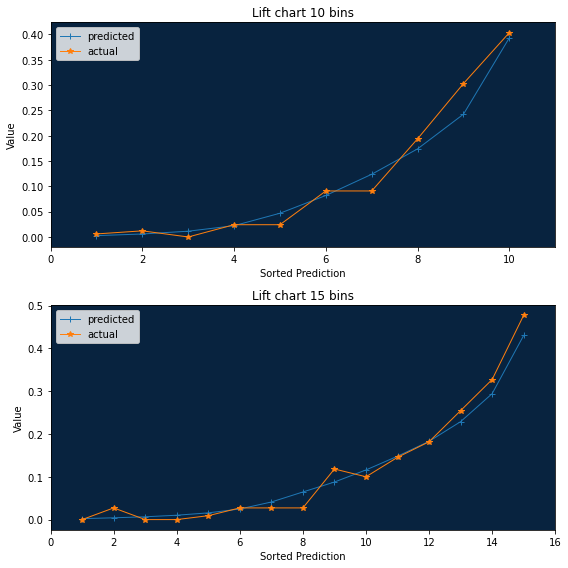

In [44]:
lift_chart = model_top.get_lift_chart("validation")

# Save the result into a pandas dataframe
lift_df = pd.DataFrame(lift_chart.bins)

bin_counts = [10, 15]
f, axarr = plt.subplots(len(bin_counts))
f.set_size_inches((8, 4 * len(bin_counts)))

rebinned_dfs = []
for i in range(len(bin_counts)):
    rebinned_dfs.append(matplotlib_lift(lift_df, bin_counts[i], axarr[i]))

plt.tight_layout()
# plt.show()

## ROC Curve

The receiver operating characteristic curve, or [ROC curve](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/roc-curve.html), is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

In [29]:
roc = model_top.get_roc_curve("validation")

# Save the result into a pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)

roc_df

accuracy  f1_score  false_negative_score  true_negative_score  \
0    0.884988  0.000000                   190                 1462   
1    0.884383  0.000000                   190                 1461   
2    0.883172  0.000000                   190                 1459   
3    0.882567  0.000000                   190                 1458   
4    0.882567  0.020202                   188                 1456   
..        ...       ...                   ...                  ...   
110  0.155569  0.214085                     0                   67   
111  0.145278  0.212054                     0                   50   
112  0.134988  0.210061                     0                   33   
113  0.125303  0.208219                     0                   17   
114  0.115012  0.206298                     0                    0   

     true_positive_score  false_positive_score  true_negative_rate  \
0                      0                     0            1.000000   
1                      0                     1            0.999316   
2                      0                     3            0.997948   
3                      0                     4            0.997264   
4                      2                     6            0.995896   
..                   ...                   ...                 ...   
110                  190                  1395            0.045828   
111                  190                  1412            0.034200   
112                  190                  1429            0.022572   
113                  190                  1445            0.011628   
114                  190                  1462            0.000000   

     false_positive_rate  true_positive_rate  \
0               0.000000            0.000000   
1               0.000684            0.000000   
2               0.002052            0.000000   
3               0.002736            0.000000   
4               0.004104            0.010526   
..                   ...                 ...   
110             0.954172            1.000000   
111             0.965800            1.000000   
112             0.977428            1.000000   
113             0.988372            1.000000   
114             1.000000            1.000000   

     matthews_correlation_coefficient  positive_predictive_value  \
0                            0.000000                   0.000000   
1                           -0.008872                   0.000000   
2                           -0.015376                   0.000000   
3                           -0.017760                   0.000000   
4                            0.029515                   0.250000   
..                                ...                        ...   
110                          0.074118                   0.119874   
111                          0.063688                   0.118602   
112                          0.051468                   0.117356   
113                          0.036759                   0.116208   
114                          0.000000                   0.115012   

     negative_predictive_value  threshold  fraction_predicted_as_positive  \
0                     0.884988   1.000000                        0.000000   
1                     0.884918   0.741994                        0.000605   
2                     0.884779   0.601053                        0.001816   
3                     0.884709   0.577989                        0.002421   
4                     0.885645   0.546934                        0.004843   
..                         ...        ...                             ...   
110                   1.000000   0.002429                        0.959443   
111                   1.000000   0.002111                        0.969734   
112                   1.000000   0.001795                        0.980024   
113                   1.000000   0.001589                        0.989709   
114                   0.000000   0.000914                        1.000000   

    

In [ ]:
dr_roc_green = "#03c75f"
white = "#ffffff"
dr_purple = "#65147D"
dr_dense_green = "#018f4f"

threshold = roc.get_best_f1_threshold()
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)

plt.scatter(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylabel("True Positive Rate")
plt.ylim([0, 1])

### Feature Impact

[Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) measures how important a feature is in the context of a model. It measures how much the accuracy of a model would decrease if that feature was removed.

Feature Impact is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once DataRobot computes the feature impact for a model, that information is saved with the project.

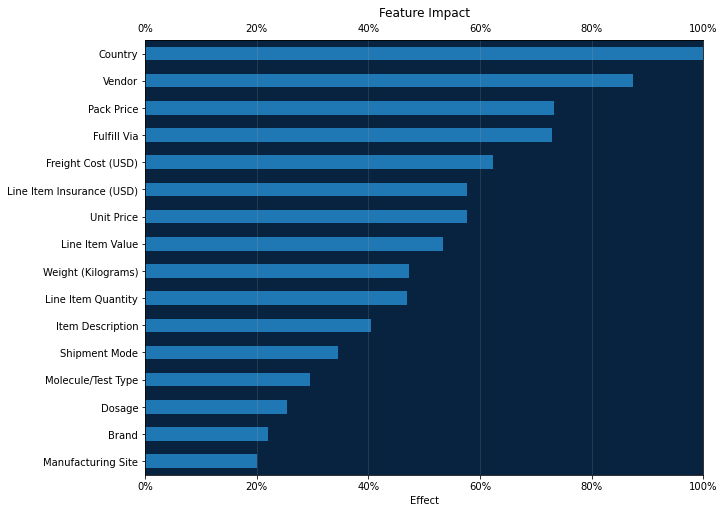

In [36]:
feature_impacts = model_top.get_or_request_feature_impact()

# Limit size to make chart look good. Display top 25 values
if len(feature_impacts) > 25:
    feature_impacts = feature_impacts[0:24]

# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by="impactNormalized", ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0 else dr_blue)

ax = impact_df.plot.barh(
    x="featureName", y="impactNormalized", legend=False, color=bar_colors, figsize=(10, 8)
)
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel("")
plt.xlabel("Effect")
plt.xlim((None, 1))  # Allow for negative impact
plt.title("Feature Impact", y=1.04);

## Make predictions

### Test predictions

After determining the top-performing model from the Leaderboard, upload the prediction test dataset to verify that the model generates predictions successfully before deploying the model to a production environment. The predictions are returned as a Pandas dataframe. 

In [ ]:
data_path_scoring = "https://pathfinder.datarobot.com/wp-content/uploads/2020/06/Pathfinder_Scoring_Predict-Parts-Shortage.xlsx"
scoring_df = pd.read_excel(data_path_scoring, engine="openpyxl")

prediction_dataset = project.upload_dataset(scoring_df)
predict_job = model_top.request_predictions(prediction_dataset.id)
prediction_dataset.id

predictions = predict_job.get_result_when_complete()
pd.concat([scoring_df, predictions], axis=1)
predictions.positive_probability.plot(kind="hist", title="Predicted Probabilities")

### Deploy a model to production


If you are happy with the model's performance, you can deploy it to a production environment with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are no longer restricted on the amount of data to score; score over 100GB with the deployment. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more.

In [33]:
# Creat a prediction server
prediction_server = dr.PredictionServer.list()[0]

# Get top performing model. Un comment if this did not execute in the previous section
# model_top = sorted_by_metric(models, 'crossValidation', metric)[0]

deployment = dr.Deployment.create_from_learning_model(
    model_top.id,
    label="Late Shipment Predictions",
    description="Predict Late Shipments",
    default_prediction_server_id=prediction_server.id,
)
deployment.id

Deployment(Late Shipment Predictions)

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

Before proceeding, provide the deployed model's deployment ID (retrieved from the deployment's [Overview tab](https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html)).

In [ ]:
deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established previously through the UI for easy scoring. Credentials are usernames and passwords, while data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

You can reference the full list of DataRobot's supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html).

Reference the DataRobot documentation for more information about [data connections](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [ ]:
dr.Credential.list()

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [6]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

5e6696ff820e737a5bd78430


### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV to CSV

In [ ]:
# Scoring without Prediction Explanations
dr.BatchPredictionJob.score(
    deployment_id,
    intake_settings={
        "type": "localFile",
        "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
    },
    output_settings={"type": "localFile", "path": "outputfile.csv"},
)

# Scoring with Prediction Explanations
dr.BatchPredictionJob.score(
    deployment_id,
    intake_settings={
        "type": "localFile",
        "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
    },
    output_settings={"type": "localFile", "path": "outputfile.csv"},
    max_explanations=3,  # Compute Prediction Explanations for the amount of features indicated here
)

#### Score from S3 to S3

In [ ]:
dr.BatchPredictionJob.score(
    deployment_id,
    intake_settings={
        "type": "s3",
        "url": "s3://theos-test-bucket/lending_club_scoring.csv",  # Provide the URL of your datastore here
        "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",  # Provide your credentials here
    },
    output_settings={
        "type": "s3",
        "url": "s3://theos-test-bucket/lending_club_scored2.csv",
        "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",
    },
)

#### Score from JDBC to JDBC

In [ ]:
dr.BatchPredictionJob.score(
    deployment_id,
    intake_settings={
        "type": "jdbc",
        "table": "table_name",
        "schema": "public",
        "dataStoreId": data_store.id,  # Provide the ID of your datastore here
        "credentialId": cred.credential_id,  # Provide your credentials here
    },
    output_settings={
        "type": "jdbc",
        "table": "table_name",
        "schema": "public",
        "statementType": "insert",
        "dataStoreId": data_store.id,
        "credentialId": cred.credential_id,
    },
)